In [1]:
import arviz as az
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import sys
from scipy.stats import mode

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '../')
from plotting_helper_funcs import *
from utils import *

rng = np.random.default_rng(seed=1234)

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now load in all of the posterior idata and the posterior predictive samples...

In [5]:
# Kholodenko 2000
K_2000_idata, K_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/kholodenko_2000/kholodenko_2000_smc_samples.json')
K_2000_post = np.load('../../../results/MAPK/param_est/synthetic_data/kholodenko_2000/kholodenko_2000_posterior_predictive_samples.npy')
# Levchenko 2000
L_2000_idata, L_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/levchenko_2000/levchenko_2000_smc_samples.json')
L_2000_post = np.load('../../../results/MAPK/param_est/synthetic_data/levchenko_2000/levchenko_2000_posterior_predictive_samples.npy')
# Hatakeyama 2003
HK_2003_idata, HK_2003_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/hatakeyama_2003/hatakeyama_2003_smc_samples.json')
HK_2003_post = np.load('../../../results/MAPK/param_est/synthetic_data/hatakeyama_2003/hatakeyama_2003_posterior_predictive_samples.npy')
# Hornberg 2005
H_2005_idata, H_2005_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/hornberg_2005/hornberg_2005_smc_samples.json') # TODO: add once smc is done
H_2005_post = np.load('../../../results/MAPK/param_est/synthetic_data/hornberg_2005/hornberg_2005_posterior_predictive_samples.npy')
# Birtwistle 2007
B_2007_idata, B_2007_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/birtwistle_2007/birtwistle_2007_smc_samples.json')
B_2007_post = np.load('../../../results/MAPK/param_est/synthetic_data/birtwistle_2007/birtwistle_2007_posterior_predictive_samples.npy')
# Orton 2009
O_2009_idata, O_2009_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/orton_2009/orton_2009_smc_samples.json') # TODO: add once smc is done
O_2009_post = np.load('../../../results/MAPK/param_est/synthetic_data/orton_2009/orton_2009_posterior_predictive_samples.npy')
# von Kreigsheim 2009
vK_2009_idata, VK_2009_ss, VK_2009_sampleTime = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/vonKriegsheim_2009/vonKriegsheim_2009_smc_samples.json', sample_time=True)
vK_2009_post = np.load('../../../results/MAPK/param_est/synthetic_data/vonKriegsheim_2009/vonKriegsheim_2009_posterior_predictive_samples.npy')
# Shin 2014
S_2014_idata, S_2014_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/shin_2014/shin_2014_smc_samples.json')
S_2014_post = np.load('../../../results/MAPK/param_est/synthetic_data/shin_2014/shin_2014_posterior_predictive_samples.npy')
# Ryu 2015
R_2015_idata, R_2015_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/ryu_2015/ryu_2015_smc_samples.json') # TODO: add once smc is done
R_2015_post = np.load('../../../results/MAPK/param_est/synthetic_data/ryu_2015/ryu_2015_posterior_predictive_samples.npy')
# Kochańczyk 2017
K_2017_idata, K_2017_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/synthetic_data/kochanczyk_2017/kochanczyk_2017_smc_samples.json') # TODO: add once smc is done
K_2017_post = np.load('../../../results/MAPK/param_est/synthetic_data/kochanczyk_2017/kochanczyk_2017_posterior_predictive_samples.npy')

# Log marginal likelihoods
S_2014_log_magr = np.mean([chain[-1] for chain in S_2014_ss['log_marginal_likelihood'][0]])
HK_2003_log_magr = np.mean([chain[-1] for chain in HK_2003_ss['log_marginal_likelihood']])
K_2000_log_magr = np.mean([chain[-1] for chain in K_2000_ss['log_marginal_likelihood'][0]])
vK_2009_log_magr = np.mean([chain[-1] for chain in VK_2009_ss['log_marginal_likelihood'][0]]) 
O_2009_log_magr = np.mean([chain[-1] for chain in O_2009_ss['log_marginal_likelihood'][0]])
R_2015_log_magr = np.mean([chain[-1] for chain in R_2015_ss['log_marginal_likelihood']])
L_2000_log_magr = np.mean([chain[-1] for chain in L_2000_ss['log_marginal_likelihood']])
K_2017_log_magr = np.mean([chain[-1] for chain in K_2017_ss['log_marginal_likelihood']])
B_2007_log_magr = np.mean([chain[-1] for chain in B_2007_ss['log_marginal_likelihood'][0]])
H_2005_log_magr = np.mean([chain[-1] for chain in H_2005_ss['log_marginal_likelihood'][0]])

model_names = ['kholodenko_2000', 'levchenko_2000', 'hatakeyama_2003','hornberg_2005', 'birtwistle_2007','orton_2009', 'vonKriegsheim_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
display_names = ['Kholodenko 2000', 'Levchenko 2000', 'Hatakeyama 2003','Hornberg 2005', 'Birtwistle 2007','Orton 2009', 'von Kriegsheim 2009', 'Shin 2014', 'Ryu 2015', 'Kochańczyk 2017']
log_marginal_likes = np.array([K_2000_log_magr, L_2000_log_magr, HK_2003_log_magr, H_2005_log_magr, B_2007_log_magr, O_2009_log_magr, vK_2009_log_magr, S_2014_log_magr, R_2015_log_magr, K_2017_log_magr])

# Birtwistle 2007 only has 400 posterior predictive samples, so we duplicate and randomly permute them 
# to get 4000
B_2007_posts = [B_2007_post for _ in range(10)]
B_2007_post = np.vstack(B_2007_posts)
B_2007_post = B_2007_post[rng.permutation(np.arange(4000))]

# vonKreigsheim 2009 only has 400 posterior predictive samples, so we duplicate and randomly permute them to get 4000
vK_2009_posts = [vK_2009_post for _ in range(10)]
vK_2009_post = np.vstack(vK_2009_posts)
vK_2009_post = vK_2009_post[rng.permutation(np.arange(4000))]

# Hornberg 2005 only has 400 posterior predictive samples, so we duplicate and randomly permute them to get 4000
H_2005_posts = [H_2005_post for _ in range(10)]
H_2005_post = np.vstack(H_2005_posts)
H_2005_post = H_2005_post[rng.permutation(np.arange(4000))]

# gather posterior samples
posterior_samples = [K_2000_post, L_2000_post, HK_2003_post, H_2005_post, B_2007_post, O_2009_post, vK_2009_post, S_2014_post, R_2015_post, K_2017_post]
shin_id = 7
# shin has 16000 so downsample to 4000
idxs = rng.choice(np.arange(16000), size=4000, replace=False)
posterior_samples[shin_id] = S_2014_post[idxs]

# create dict of idata
dict_compare = {'kholodenko_2000': K_2000_idata, 'levchenko_2000':L_2000_idata,'hatakeyama_2003': HK_2003_idata, 'hornberg_2005':H_2005_idata,'birtwistle_2007':B_2007_idata,'orton_2009':O_2009_idata,
'vonKriegsheim_2009':vK_2009_idata, 'shin_2014': S_2014_idata, 'ryu_2015': R_2015_idata, 'kochanczyk_2017': K_2017_idata}

# get data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')

# set up a color palette
colors = sns.color_palette('pastel', n_colors=len(model_names)+3)

# sns.color_palette("husl", len(model_names)+2)

Now run arviz model comparison get eldpd_loo for each model and save to a dict

In [7]:
compare_data_waic_pbma = az.compare(dict_compare, ic='waic', method='BB-pseudo-BMA')
compare_data_loo_pbma = az.compare(dict_compare, ic='loo', method='BB-pseudo-BMA')
compare_data_waic_stack = az.compare(dict_compare, ic='waic', method='stacking')
compare_data_loo_stack = az.compare(dict_compare, ic='loo', method='stacking')

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/sit

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_72057/4120006267.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_72057/4120006267.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)


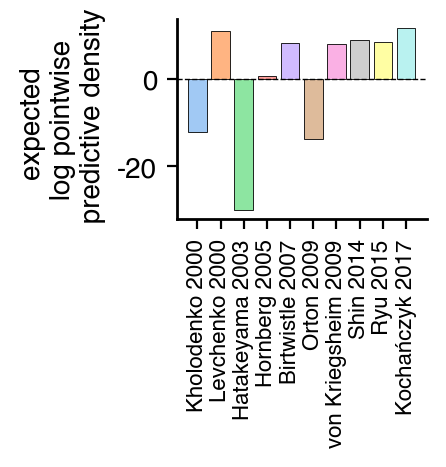

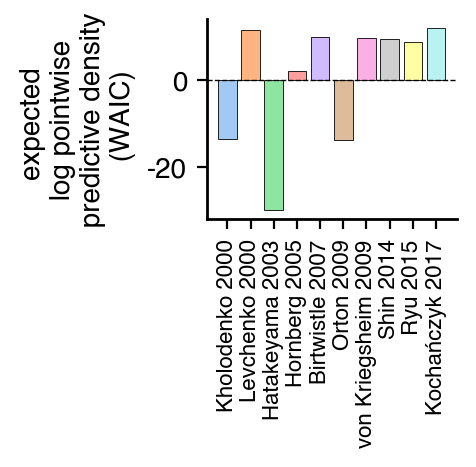

In [8]:
# make a plot of elpd_loo, and elpd_waic
dat = [compare_data_loo_stack.loc[model]['elpd_loo'] for model in model_names]
fig, ax = get_sized_fig_ax(1.25, 1.)
bar = ax.bar(model_names, dat, edgecolor='k')
ax.set_ylabel('expected \n log pointwise \n predictive density', fontsize=10)
ax.set_yticks([-20, 0])
ax.set_yticklabels([-20, 0], fontsize=10.0)
ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
fig.savefig('../../../results/MAPK/mmi/mapk_elpd_loo.pdf', transparent=True)

# waic
dat = [compare_data_waic_stack.loc[model]['elpd_waic'] for model in model_names]
fig, ax = get_sized_fig_ax(1.25, 1.)
bar = ax.bar(model_names, dat, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])

ax.set_ylabel('expected \n log pointwise \n predictive density \n (WAIC)', fontsize=10)
ax.set_yticks([-20, 0])
ax.set_yticklabels([-20, 0], fontsize=10.0)
ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
fig.savefig('../../../results/MAPK/mmi/mapk_elpd_waic.pdf', transparent=True)

Bayesian model averaging - plot bar plot of model probabilities

[-10.55782407   5.02413276 -31.43088824  -7.6129868    5.33193453
 -28.36095985   4.75012892   7.68601559   6.40375142   7.58190537]


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_72057/1473629885.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)


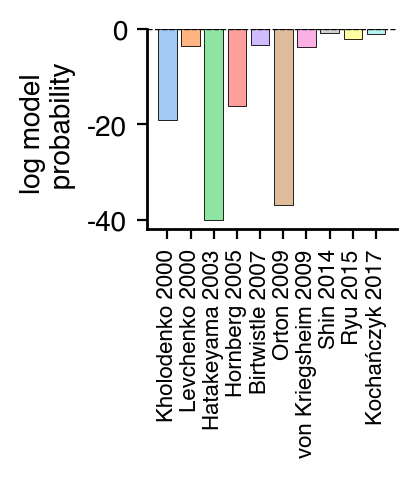

In [9]:
n_models = len(log_marginal_likes)
prior_prob = 1/n_models

normalizing_constant = np.sum(prior_prob*np.exp(log_marginal_likes))
model_probs = prior_prob*np.exp(log_marginal_likes)/normalizing_constant
print(log_marginal_likes)
fig, ax = get_sized_fig_ax(1.25, 1.)
bar = ax.bar(model_names, np.log(model_probs), edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])

ax.set_ylabel('log model \n probability', fontsize=10)
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_yticks([0, -20, -40])
ax.set_yticklabels([0, -20, -40], fontsize=10.0)
ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)
# ax.set_ylim([0, 1.0])
fig.savefig('../../../results/MAPK/mmi/mapk_model_prob.pdf', transparent=True)

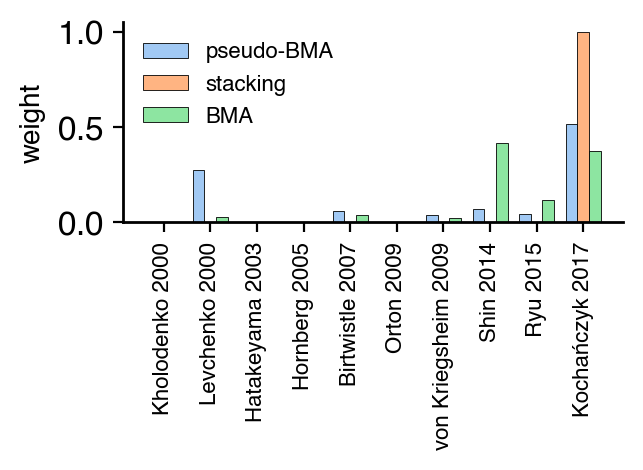

In [10]:
x = np.arange(n_models)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

stack = [compare_data_loo_stack.loc[model]['weight'] for model in model_names]
pBMA = [compare_data_loo_pbma.loc[model]['weight'] for model in model_names]


fig, ax = get_sized_fig_ax(2.5, 1.)
for dat, name, col in zip([pBMA, stack, model_probs], ['pseudo-BMA','stacking','BMA',], [colors[-3], colors[-2], colors[-1]]):
    offset = width * multiplier
    bar = ax.bar(x + offset, dat, width, label=name, color=col, edgecolor='k')
    # ax.bar_label(bar, padding=3)
    multiplier += 1

ax.set_ylabel('model weight', fontsize=10)
ax.set_xticks(x + width, display_names)
ax.legend(loc='upper left', fontsize=8.0)

ax.set_ylabel(r'weight', fontsize=10)
ax.set_xticklabels(display_names, rotation=90, fontsize=8.0)
# ax.set_ylim([0, 1.0])
fig.savefig('../../../results/MAPK/mmi/mapk_model_weights.pdf', transparent=True)

Generate predictive samples from the averaged predictive density

In [11]:
loo_pbma_combined = np.zeros_like(posterior_samples[0])
loo_stack_combined = np.zeros_like(posterior_samples[0])
loo_bma_combined = np.zeros_like(posterior_samples[0])
for i, name in enumerate(model_names):
    loo_pbma_combined += compare_data_loo_pbma.loc[name]['weight']*posterior_samples[i]
    loo_stack_combined += compare_data_loo_stack.loc[name]['weight']*posterior_samples[i]
    loo_bma_combined += model_probs[i]*posterior_samples[i]

In [12]:
def plot_stimulus_response_curve(samples, data, inputs, box_color='k', data_color='r', input_name='EGF stimulus', 
                                 output_name='% maximal ERK activity',
                                 data_std=0.1, width=6.0, height=3.0, scatter_marker_size=50, data_marker_size=7):
    dat = {}
    for i,input in enumerate(inputs):
        dat[input] = samples[:,i]

    data_df = pd.DataFrame(dat)

    fig, ax = get_sized_fig_ax(width, height)
    sns.boxplot(data=data_df, color=box_color, ax=ax, whis=(2.5, 97.5), fill=True, 
                native_scale=True, log_scale=(10, 0), fliersize=0, width=0.65)
    ax.set_xlabel(input_name)
    ax.set_ylabel(output_name)

    errors = data_std*np.squeeze(np.ones_like(data))
    ax.scatter(inputs, data, color=data_color, marker='x', s=scatter_marker_size, zorder=10, label='synthetic data')
    ax.errorbar(inputs, np.squeeze(data), yerr=errors, color=data_color, fmt='x', markersize=data_marker_size, zorder=10)

    return fig, ax

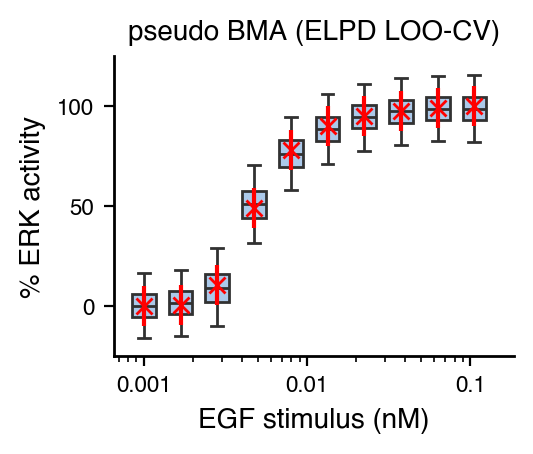

In [13]:
fig, ax = plot_stimulus_response_curve(loo_pbma_combined, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% ERK activity', box_color=colors[-3], data_color='r',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
ax.set_title('pseudo BMA (ELPD LOO-CV)', fontsize=10)
leg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/mapk_pbma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)

fig.savefig('../../../results/MAPK/mmi/mapk_pbma_avg.pdf', transparent=True)

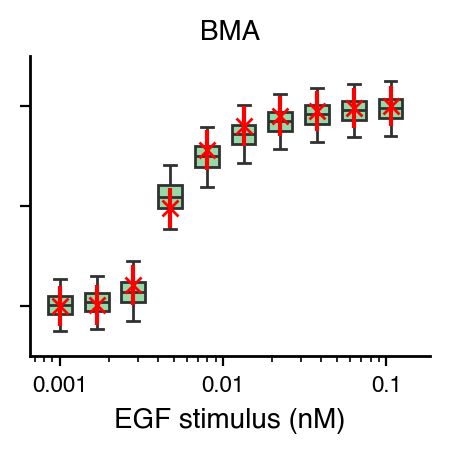

In [14]:
fig, ax = plot_stimulus_response_curve(loo_bma_combined, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-1], data_color='r',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
ax.set_title('BMA', fontsize=10)
leg = ax.legend()

eg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/mapk_bma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=8)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')


fig.savefig('../../../results/MAPK/mmi/mapk_bma_avg.pdf', transparent=True)

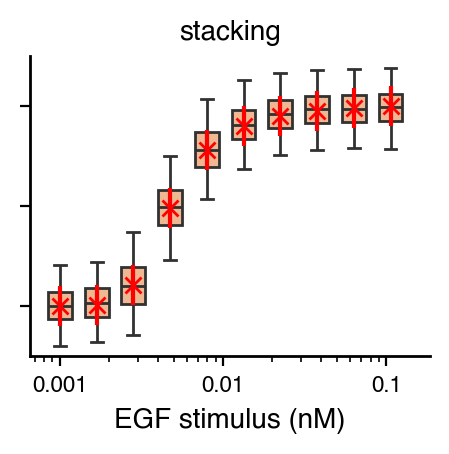

In [15]:
fig, ax = plot_stimulus_response_curve(loo_stack_combined, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-2], data_color='r',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)

ax.set_title('stacking', fontsize=10)
leg = ax.legend()

eg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/mapk_stack_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=8)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')


fig.savefig('../../../results/MAPK/mmi/mapk_stack_avg.pdf', transparent=True)

Now compute RMSE for each model. Will do this for each model averaged predictive sample then make a bar plot with error bars

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_72057/3033137449.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)


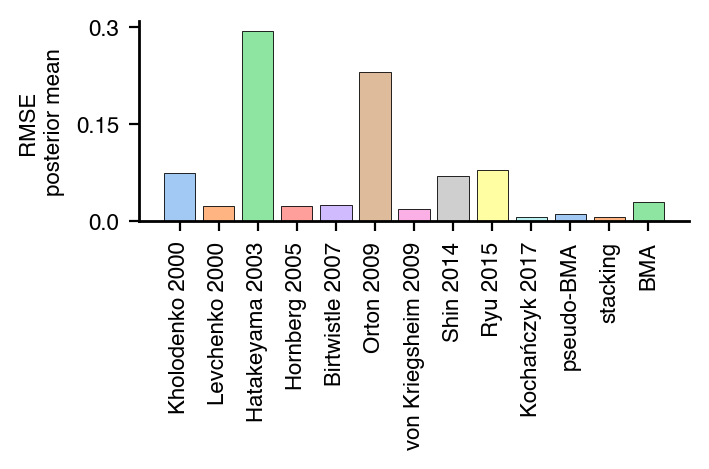

In [16]:
RMSE_samples = []
RMSE_stds = []
for i, name in enumerate(model_names):
    RMSE_samples.append(np.sqrt(np.mean((np.mean(posterior_samples[i], axis=0) - data.T)**2)))
    RMSE_stds.append(np.sqrt(np.mean((np.std(posterior_samples[i], axis=0) - data.T)**2)))

# add RMSE for BMA and pseudo-BMA
RMSE_samples.append(np.sqrt(np.mean((np.mean(loo_pbma_combined, axis=0) - data.T)**2)))
RMSE_stds.append(np.sqrt(np.mean((np.std(posterior_samples[i], axis=0) - data.T)**2)))
RMSE_samples.append(np.sqrt(np.mean((np.mean(loo_stack_combined, axis=0) - data.T)**2)))
RMSE_samples.append(np.sqrt(np.mean((np.mean(loo_bma_combined, axis=0) - data.T)**2)))
# make a plot
fig, ax = get_sized_fig_ax(2.75, 1.)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], RMSE_samples, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
    
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_ylabel('RMSE \n posterior mean ', fontsize=8.0)
ax.set_yticks([0.0, 0.15, 0.3])
ax.set_yticklabels([0.0, 0.15, 0.3], fontsize=8.0)
fig.savefig('../../../results/MAPK/mmi/mapk_RMSE.pdf', transparent=True)

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_72057/2290514212.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_72057/2290514212.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)


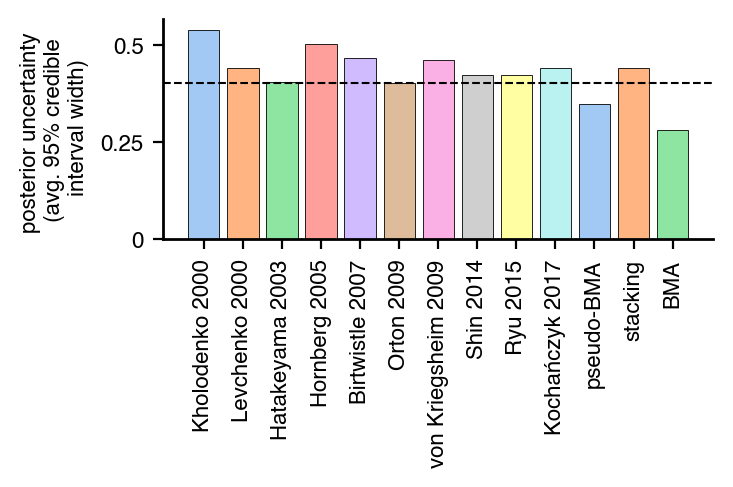

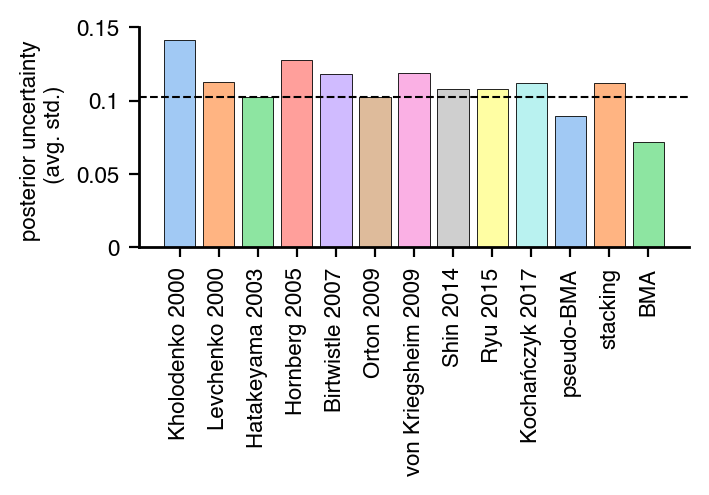

In [41]:
posterior_uncertainty_95 = []
for i, name in enumerate(model_names):
    posterior_uncertainty_95.append(np.mean(np.diff(np.quantile(posterior_samples[i], [0.025, 0.975], axis=0), axis=0)))

# get index of min uncertainty
min_index_95 = np.argmin(posterior_uncertainty_95)

# add RMSE for BMA and pseudo-BMA
posterior_uncertainty_95.append(np.mean(np.diff(np.quantile(loo_pbma_combined, [0.025, 0.975], axis=0), axis=0)))
posterior_uncertainty_95.append(np.mean(np.diff(np.quantile(loo_stack_combined, [0.025, 0.975], axis=0), axis=0)))
posterior_uncertainty_95.append(np.mean(np.diff(np.quantile(loo_bma_combined, [0.025, 0.975], axis=0), axis=0)))

# make a plot
fig, ax = get_sized_fig_ax(2.75, 1.1)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], posterior_uncertainty_95, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [posterior_uncertainty_95[min_index_95]]*2, 'k--', linewidth=0.75)
ax.set_xlim(xlim)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=8.0)
ax.set_yticks([0, 0.25, 0.5])
ax.set_yticklabels([0, 0.25, 0.5], fontsize=8.0)
fig.savefig('../../../results/MAPK/mmi/mapk_post_uncert_95.pdf', transparent=True)

posterior_uncertainty_std = []
for i, name in enumerate(model_names):
    posterior_uncertainty_std.append(np.mean(np.std(posterior_samples[i], axis=0)))

# get index of min uncertainty
min_index_std = np.argmin(posterior_uncertainty_std)

# add RMSE for BMA and pseudo-BMA
posterior_uncertainty_std.append(np.mean(np.std(loo_pbma_combined, axis=0)))
posterior_uncertainty_std.append(np.mean(np.std(loo_stack_combined, axis=0)))
posterior_uncertainty_std.append(np.mean(np.std(loo_bma_combined, axis=0)))

# make a plot
fig, ax = get_sized_fig_ax(2.75, 1.1)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], posterior_uncertainty_std, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [posterior_uncertainty_std[min_index_std]]*2, 'k--', linewidth=0.75)
ax.set_xlim(xlim)
ax.set_yticks([0, 0.05, 0.1, 0.15])
ax.set_yticklabels([0, 0.05, 0.1, 0.15], fontsize=8.0)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_ylabel('posterior uncertainty \n (avg. std.)', fontsize=8.0)
fig.savefig('../../../results/MAPK/mmi/mapk_post_uncert_std.pdf', transparent=True)

In [38]:
model_avg_stats = {
    'RMSE':{
        'pBMA':RMSE_samples[-3],
        'BMA':RMSE_samples[-1],
        'stacking':RMSE_samples[-2],
    },
    'credible_95':{
        'pBMA':posterior_uncertainty_95[-3],
        'BMA':posterior_uncertainty_95[-1],
        'stacking':posterior_uncertainty_95[-2],
    },  
}

with open('../../../results/MAPK/mmi/all_models_MMI_stats.json', 'w') as file:
    file.write(json.dumps(model_avg_stats))

### Make MMI predictions of dynamcis

In [39]:
# load posterior predictions of dynamics
# Kholodenko 2000
K_2000_traj = []
K_2000_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/kholodenko_2000/EGF_normalized_0.001.npy'))
K_2000_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/kholodenko_2000/EGF_normalized_0.0047315125896148.npy'))
K_2000_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/kholodenko_2000/EGF_normalized_0.1059253725177288.npy'))
K_2000_traj = np.array(K_2000_traj)

# Levchenko 2000
L_2000_traj = []
L_2000_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/levchenko_2000/EGF_normalized_0.001.npy'))
L_2000_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/levchenko_2000/EGF_normalized_0.0047315125896148.npy'))
L_2000_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/levchenko_2000/EGF_normalized_0.1059253725177288.npy'))
L_2000_traj = np.array(L_2000_traj)

# Hatakeyama 2003
HK_2003_traj = []
HK_2003_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/hatakeyama_2003/EGF_normalized_0.001.npy'))
HK_2003_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/hatakeyama_2003/EGF_normalized_0.0047315125896148.npy'))
HK_2003_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/hatakeyama_2003/EGF_normalized_0.1059253725177288.npy'))
HK_2003_traj = np.array(HK_2003_traj)

# Hornberg 2005
H_2005_traj = []
H_2005_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/hornberg_2005/EGF_normalized_0.001.npy'))
H_2005_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/hornberg_2005/EGF_normalized_0.0047315125896148.npy'))
H_2005_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/hornberg_2005/EGF_normalized_0.1059253725177288.npy'))
H_2005_traj = np.array(H_2005_traj)

# Birtwistle 2007
B_2007_traj = []
B_2007_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/birtwistle_2007/EGF_normalized_0.001.npy'))
B_2007_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/birtwistle_2007/EGF_normalized_0.0047315125896148.npy'))
B_2007_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/birtwistle_2007/EGF_normalized_0.1059253725177288.npy'))
B_2007_traj = np.array(B_2007_traj)

# Orton 2009
O_2009_traj = []
O_2009_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/orton_2009/EGF_normalized_0.001.npy'))
O_2009_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/orton_2009/EGF_normalized_0.0047315125896148.npy'))
O_2009_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/orton_2009/EGF_normalized_0.1059253725177288.npy'))
O_2009_traj = np.array(O_2009_traj)

# Von Kreigsheim 2009
# TODO: adme once smc is done

# Shin 2014
S_2014_traj = []
S_2014_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/shin_2014/EGF_normalized_0.001.npy'))
S_2014_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/shin_2014/EGF_normalized_0.0047315125896148.npy'))
S_2014_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/shin_2014/EGF_normalized_0.1059253725177288.npy'))
S_2014_traj = np.array(S_2014_traj)

# Ryu 2015
R_2015_traj = []
R_2015_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/ryu_2015/EGF_normalized_0.001.npy'))
R_2015_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/ryu_2015/EGF_normalized_0.0047315125896148.npy'))
R_2015_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/ryu_2015/EGF_normalized_0.1059253725177288.npy'))
R_2015_traj = np.array(R_2015_traj)

# Kochańczyk 2017
K_2017_traj = []
K_2017_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/kochanczyk_2017/EGF_normalized_0.001.npy'))
K_2017_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/kochanczyk_2017/EGF_normalized_0.0047315125896148.npy'))
K_2017_traj.append(np.load('../../../results/MAPK/param_est/synthetic_data/kochanczyk_2017/EGF_normalized_0.1059253725177288.npy'))
K_2017_traj = np.array(K_2017_traj)

trajs = {'kholodenko_2000':K_2000_traj, 
        'levchenko_2000':L_2000_traj, 
        'hatakeyama_2003':HK_2003_traj,
        'hornberg_2005':H_2005_traj,
        'birtwistle_2007':B_2007_traj,
        'orton_2009':O_2009_traj,
        'shin_2014':S_2014_traj,
        'ryu_2015':R_2015_traj,
        'kochanczyk_2017':K_2017_traj}

Now perform weighted averaging of the posterior predictive samples from each model

In [40]:
loo_pbma_combined_traj = np.zeros_like(K_2000_traj)
loo_stack_combined_traj = np.zeros_like(K_2000_traj)
loo_bma_combined_traj = np.zeros_like(K_2000_traj)
for i, name in enumerate(model_names):
    loo_pbma_combined_traj += compare_data_loo_pbma.loc[name]['weight']*trajs[name]
    loo_stack_combined_traj += compare_data_loo_stack.loc[name]['weight']*trajs[name]
    loo_bma_combined_traj += model_probs[i]*trajs[name]

# load inputs and HF data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')
HF_trajs = np.load('../../../results/MAPK/HF_96_trajs.npy')
HF_traj_times = np.load('../../../results/MAPK/HF_96_traj_times.npy')
HF_trajs = np.squeeze(HF_trajs)
HF_trajs_norm = HF_trajs/np.max(HF_trajs)

# convert to dicts
input_idxs = [0,3,9]
pbma_traj_dict = {}
stack_traj_dict = {}
bma_traj_dict = {}

for i, idx in enumerate(input_idxs):
    pbma_traj_dict[inputs[idx]] = loo_pbma_combined_traj[i,:,:]
    stack_traj_dict[inputs[idx]] = loo_stack_combined_traj[i,:,:]
    bma_traj_dict[inputs[idx]] = loo_bma_combined_traj[i,:,:]

times = np.linspace(0.0, 240.0, loo_bma_combined_traj.shape[2])

/scratch/nlinden/multimodel-inference/src/MAPK/multimodel_inference/../utils.py:769: UserWarning: FixedFormatter should only be used together with FixedLocator
  s_ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/multimodel_inference/../utils.py:811: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/multimodel_inference/../utils.py:769: UserWarning: FixedFormatter should only be used together with FixedLocator
  s_ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/multimodel_inference/../utils.py:811: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/multimodel_inference/../utils.py:769: UserWarning: FixedFormatter should only be used together with F

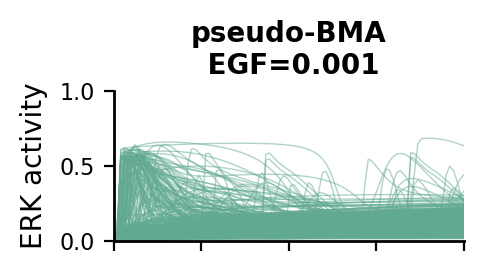

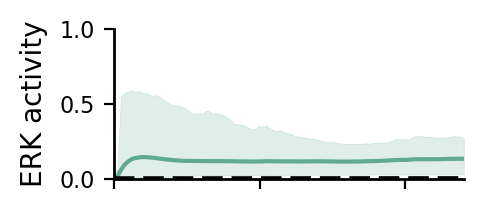

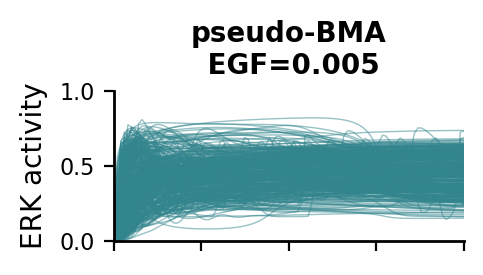

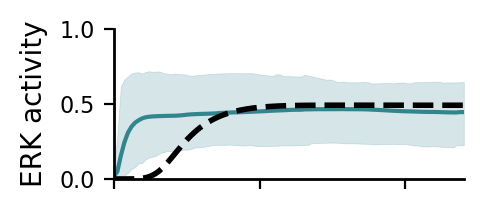

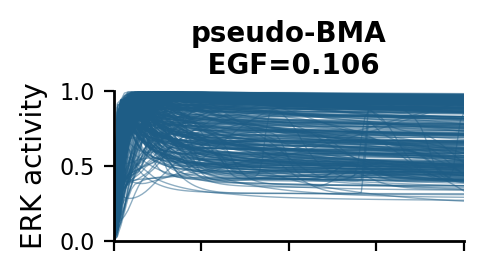

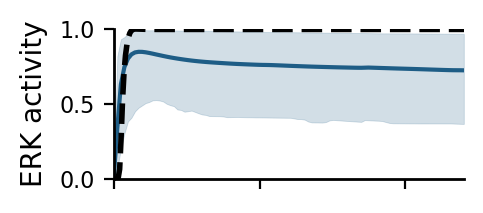

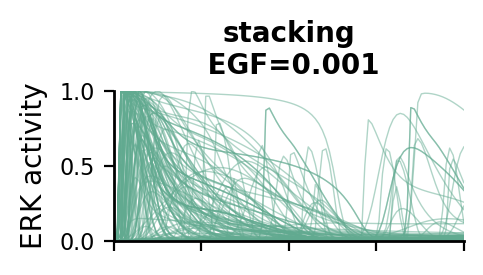

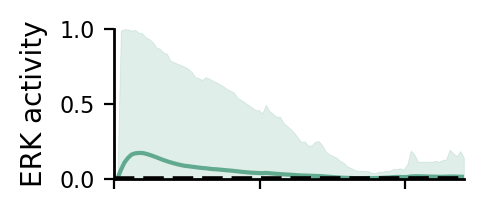

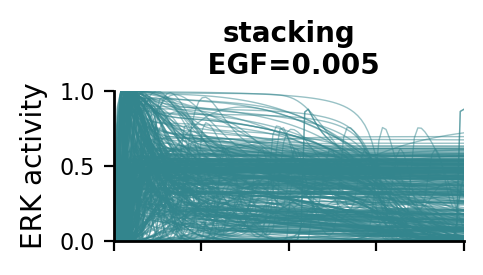

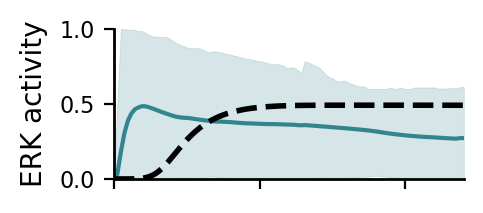

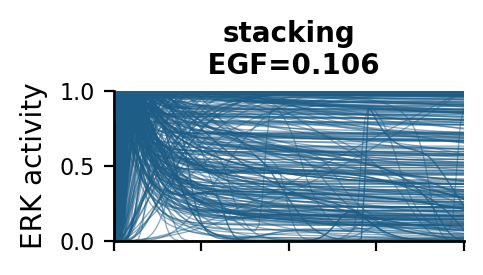

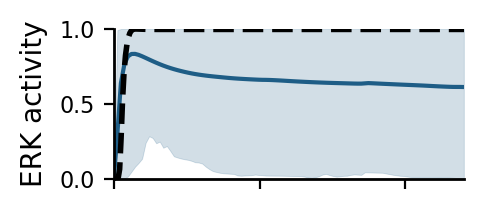

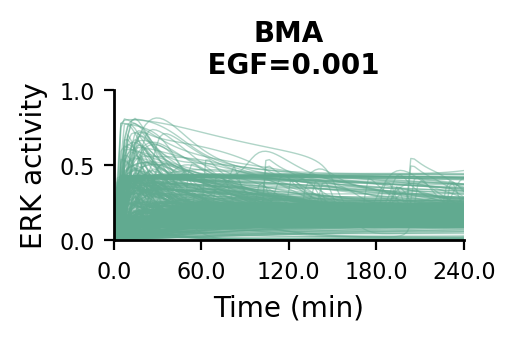

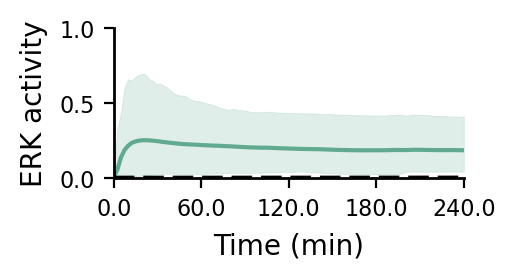

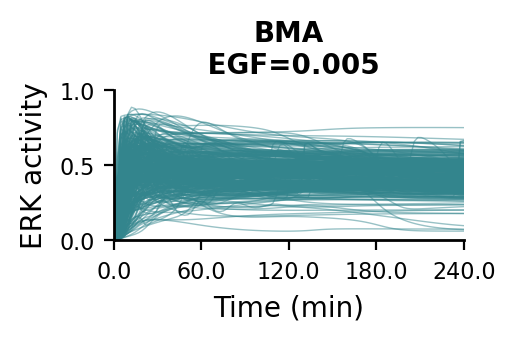

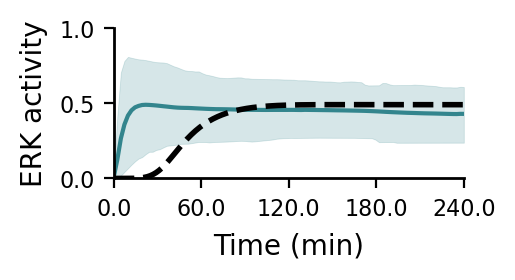

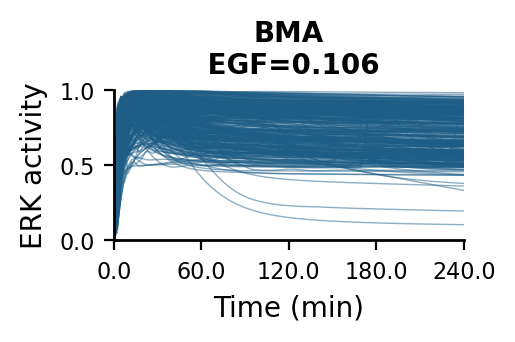

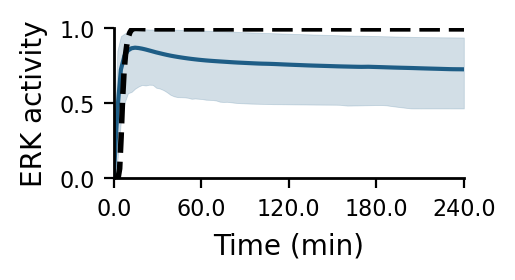

In [41]:
# make plot
fig_savedir = '../../../figures/MAPK/mmi/'
make_traj_plots('pBMA', 'pseudo-BMA', inputs[input_idxs], 400, pbma_traj_dict, times, fig_savedir, HF_trajs_norm[input_idxs], HF_traj_times, maxT=240.0, show_xlabels=False)
make_traj_plots('stack', 'stacking', inputs[input_idxs], 400, stack_traj_dict, times, fig_savedir, HF_trajs_norm[input_idxs], HF_traj_times, maxT=240.0, show_xlabels=False)
make_traj_plots('BMA', 'BMA', inputs[input_idxs], 400, bma_traj_dict, times, fig_savedir, HF_trajs_norm[input_idxs], HF_traj_times, maxT=240.0)

#### Compute posterior RMSE and Uncertainty

In [42]:
# we need to interpolate the HF_traj data to get it at the same times as the other data
HF_trajs_interp = []
for i, input in enumerate(inputs[input_idxs]):
    HF_trajs_interp.append(np.interp(times, HF_traj_times, HF_trajs_norm[input_idxs[i]]))
HF_trajs_interp = np.array(HF_trajs_interp)

RMSE = {}
credible_95 = {}
for name in model_names:
    RMSE[name] = np.sqrt(np.mean((np.mean(trajs[name], axis=1) - HF_trajs_interp)**2, axis=1))
    credible_95[name] = np.mean(np.squeeze(np.diff(np.quantile(trajs[name], [0.025, 0.975], axis=1), axis=0)), axis=1)

# add RMSE for BMA pseudo-BMA, and stacking
RMSE['pseudo-BMA'] = np.sqrt(np.mean((np.mean(loo_pbma_combined_traj, axis=1) - HF_trajs_interp)**2, axis=1))
credible_95['pseudo-BMA'] = np.mean(np.squeeze(np.diff(np.quantile(loo_pbma_combined_traj, [0.025, 0.975], axis=1), axis=0)), axis=1)

RMSE['stacking'] = np.sqrt(np.mean((np.mean(loo_stack_combined_traj, axis=1) - HF_trajs_interp)**2, axis=1))
credible_95['stacking'] = np.mean(np.squeeze(np.diff(np.quantile(loo_stack_combined_traj, [0.025, 0.975], axis=1), axis=0)), axis=1)

RMSE['BMA'] = np.sqrt(np.mean((np.mean(loo_bma_combined_traj, axis=1) - HF_trajs_interp)**2, axis=1))
credible_95['BMA'] = np.mean(np.squeeze(np.diff(np.quantile(loo_bma_combined_traj, [0.025, 0.975], axis=1), axis=0)), axis=1)

/tmp/ipykernel_3318961/1179061505.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
/tmp/ipykernel_3318961/1179061505.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
/tmp/ipykernel_3318961/1179061505.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
/tmp/ipykernel_3318961/1179061505.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)


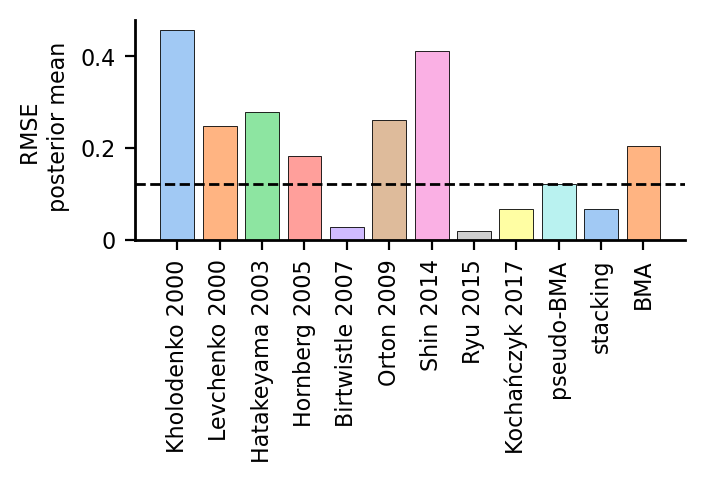

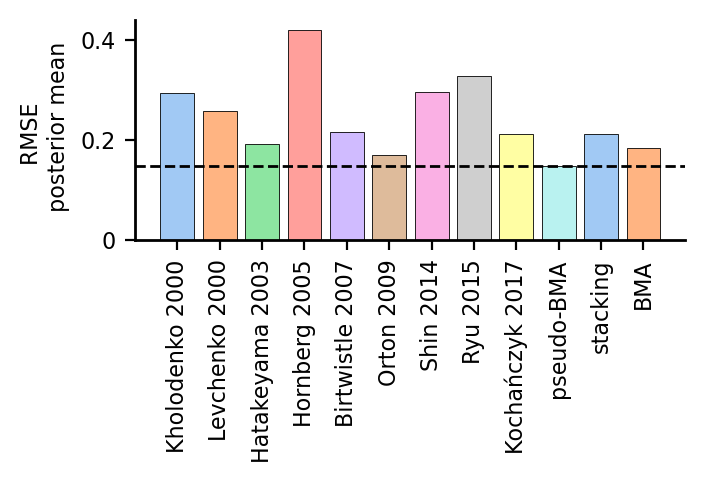

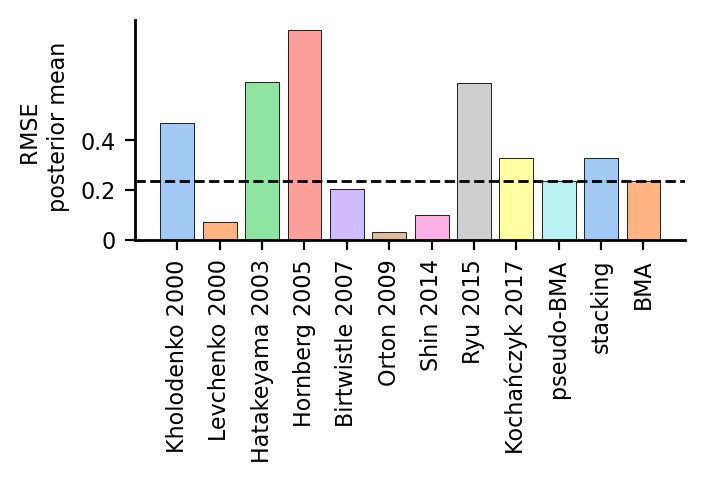

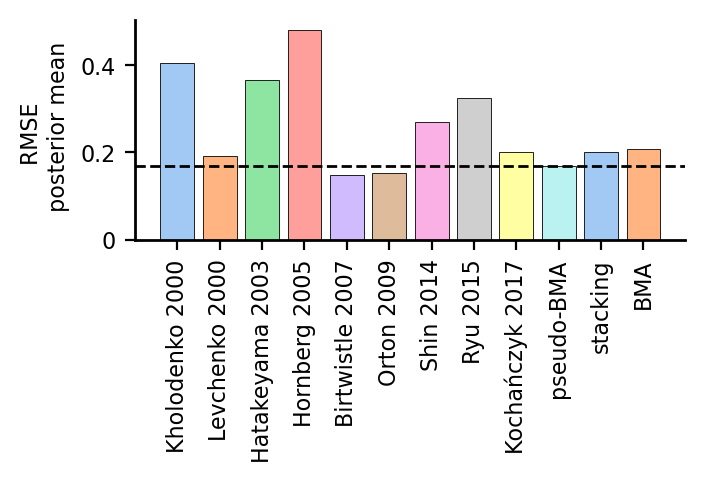

In [43]:
# make a plot
fig, ax = get_sized_fig_ax(2.75, 1.1)
names = model_names + ['pseudo-BMA', 'stacking', 'BMA']

bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], [RMSE[name][0] for name in names], edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [RMSE['pseudo-BMA'][0]]*2, 'k--', linewidth=1.)
ax.set_xlim(xlim)
ax.set_yticks([0, 0.2, 0.4])
ax.set_yticklabels([0, 0.2, 0.4], fontsize=8.0)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_ylabel('RMSE \n posterior mean', fontsize=8.0)
fig.savefig(os.path.join(fig_savedir, 'avg_RMSE_EGF_{}.pdf'.format(inputs[input_idxs[0]])), transparent=True)

fig, ax = get_sized_fig_ax(2.75, 1.1)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], [RMSE[name][1] for name in names], edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [RMSE['pseudo-BMA'][1]]*2, 'k--', linewidth=1.)
ax.set_xlim(xlim)
ax.set_yticks([0, 0.2, 0.4])
ax.set_yticklabels([0, 0.2, 0.4], fontsize=8.0)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_ylabel('RMSE \n posterior mean', fontsize=8.0)
fig.savefig(os.path.join(fig_savedir, 'avg_RMSE_EGF_{}.pdf'.format(inputs[input_idxs[1]])), transparent=True)

fig, ax = get_sized_fig_ax(2.75, 1.1)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], [RMSE[name][2] for name in names], edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [RMSE['pseudo-BMA'][2]]*2, 'k--', linewidth=1.)
ax.set_xlim(xlim)
ax.set_yticks([0, 0.2, 0.4])
ax.set_yticklabels([0, 0.2, 0.4], fontsize=8.0)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_ylabel('RMSE \n posterior mean', fontsize=8.0)
fig.savefig(os.path.join(fig_savedir, 'avg_RMSE_EGF_{}.pdf'.format(inputs[input_idxs[2]])), transparent=True)

# total RMSE
fig, ax = get_sized_fig_ax(2.75, 1.1)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], [np.mean(RMSE[name]) for name in names], edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [np.mean(RMSE['pseudo-BMA'])]*2, 'k--', linewidth=1.)
ax.set_xlim(xlim)
ax.set_yticks([0, 0.2, 0.4])
ax.set_yticklabels([0, 0.2, 0.4], fontsize=8.0)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_ylabel('RMSE \n posterior mean', fontsize=8.0)
fig.savefig(os.path.join(fig_savedir, 'avg_RMSE_all.pdf'.format(inputs[input_idxs[2]])), transparent=True)


/tmp/ipykernel_3318961/4042427260.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
/tmp/ipykernel_3318961/4042427260.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
/tmp/ipykernel_3318961/4042427260.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)


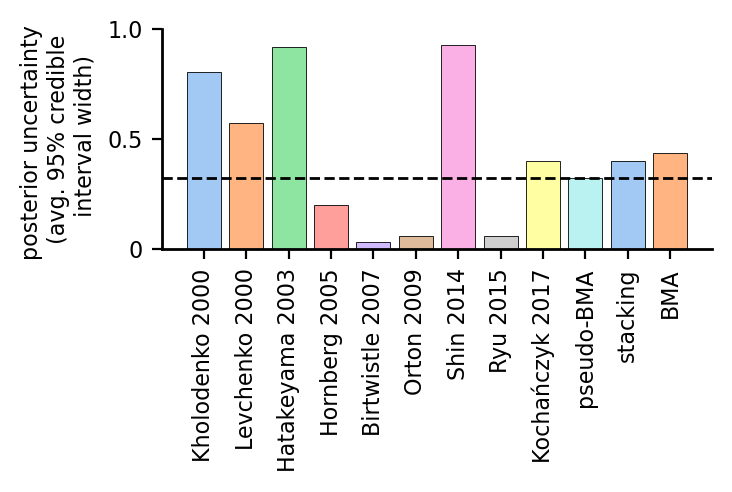

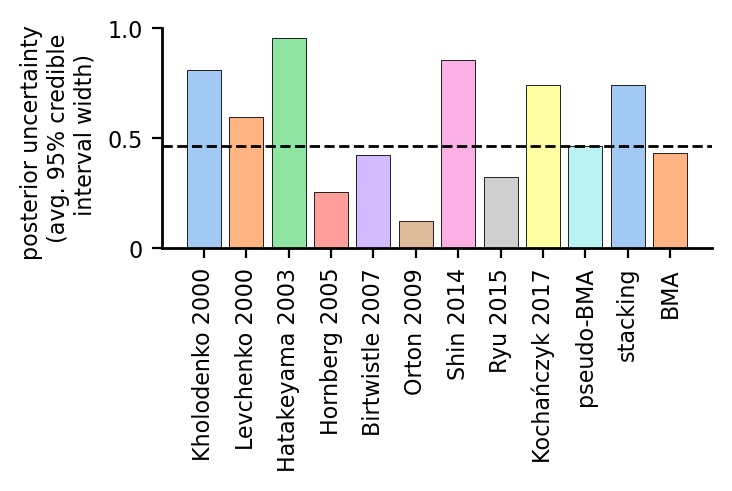

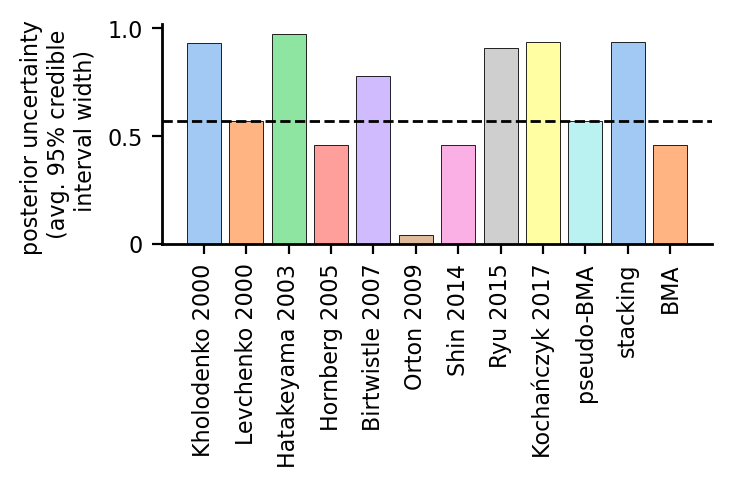

In [44]:
# make a plot
fig, ax = get_sized_fig_ax(2.75, 1.1)
names = model_names + ['pseudo-BMA', 'stacking', 'BMA']

bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], [credible_95[name][0] for name in names], edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [credible_95['pseudo-BMA'][0]]*2, 'k--', linewidth=1.)
ax.set_xlim(xlim)
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels([0, 0.5, 1.0], fontsize=8.0)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=8.0)
fig.savefig(os.path.join(fig_savedir, 'avg_cred_95_EGF_{}.pdf'.format(inputs[input_idxs[0]])), transparent=True)

fig, ax = get_sized_fig_ax(2.75, 1.1)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], [credible_95[name][1] for name in names], edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [credible_95['pseudo-BMA'][1]]*2, 'k--', linewidth=1.)
ax.set_xlim(xlim)
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels([0, 0.5, 1.0], fontsize=8.0)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=8.0)
fig.savefig(os.path.join(fig_savedir, 'avg_cred_95_EGF_{}.pdf'.format(inputs[input_idxs[1]])), transparent=True)

fig, ax = get_sized_fig_ax(2.75, 1.1)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], [credible_95[name][2] for name in names], edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [credible_95['pseudo-BMA'][2]]*2, 'k--', linewidth=1.)
ax.set_xlim(xlim)
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels([0, 0.5, 1.0], fontsize=8.0)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=8.0)
fig.savefig(os.path.join(fig_savedir, 'avg_cred_95_EGF_{}.pdf'.format(inputs[input_idxs[2]])), transparent=True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


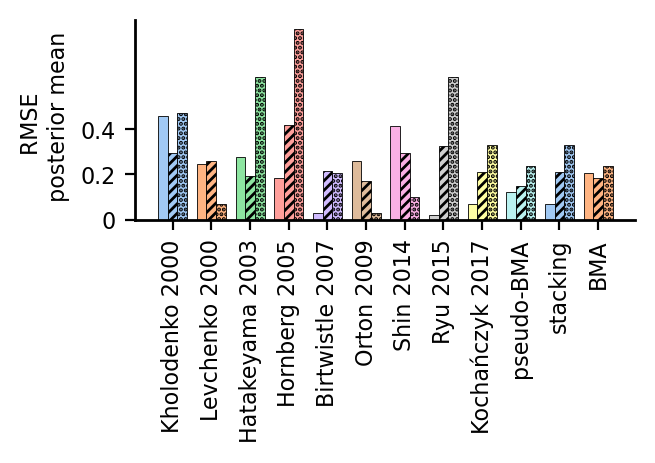

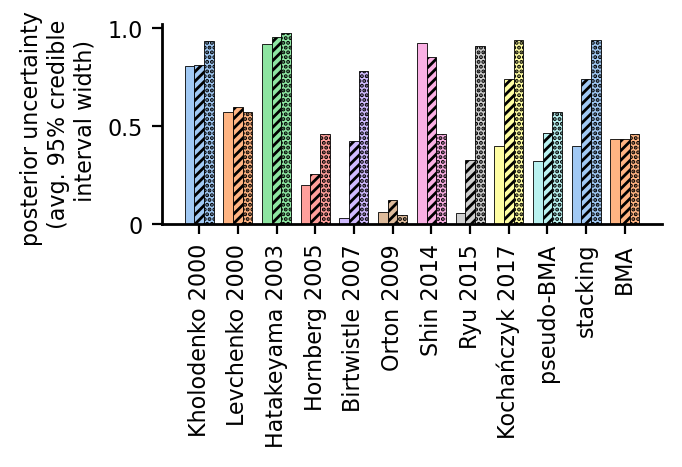

In [45]:
x = np.arange(n_models+3)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

## RMSE
fig, ax = get_sized_fig_ax(2.5, 1.)
for i, hatch in enumerate(['', '///////', '.......']):
    offset = width * multiplier
    bar = ax.bar(x+offset, [RMSE[name][i] for name in names], edgecolor='k', hatch=hatch, width=width)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
    multiplier += 1

ax.set_ylabel('model weight', fontsize=10)
ax.set_xticks(x + width, display_names+['pseudo-BMA', 'stacking', 'BMA'])
ax.legend(loc='upper left', fontsize=8.0)

ax.set_ylabel('RMSE \n posterior mean', fontsize=8.0)
ax.set_xticklabels(display_names+['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_yticks([0,0.2,0.4])
ax.set_yticklabels([0,0.2,0.4], fontsize=8.0)
fig.savefig(os.path.join(fig_savedir, 'avg_RMSE_all_EGF.pdf'), transparent=True)

multiplier = 0
## Credible Interval Width
fig, ax = get_sized_fig_ax(2.5, 1.)
for i, hatch in enumerate(['', '///////', '.......']):
    offset = width * multiplier
    bar = ax.bar(x+offset, [credible_95[name][i] for name in names], edgecolor='k', hatch=hatch, width=width)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
    multiplier += 1

ax.set_ylabel('model weight', fontsize=10)
ax.set_xticks(x + width, display_names+['pseudo-BMA', 'stacking', 'BMA'])
ax.legend(loc='upper left', fontsize=8.0)

ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=8.0)
ax.set_xticklabels(display_names+['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=8.0)
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels([0, 0.5, 1.0], fontsize=8.0)
fig.savefig(os.path.join(fig_savedir, 'avg_cred_95_all_EGF.pdf'), transparent=True)